In [34]:
import seaborn as sns 
import pandas as pd 
import matplotlib.pyplot as plt
import pickle
import pyLDAvis
import pyLDAvis.gensim  # or pyLDAvis.gensim_models if using Gensim >= 4.0
import gensim
import gensim.corpora as corpora

## Data Collection and Extraction

The dataset originates from the 5 Million Songs dataset. Due to its immense size, extensive data processing and modeling were necessary to tailor a dataset suitable for analysis. Specifically, only songs released between 1950 and 2020 were retained, while earlier songs were excluded.

Given the dataset's magnitude, it was divided by decades. A consistent approach was applied to each decade's dataset:
- The "misc" category was removed. This category encompassed non-song entries, such as texts and poems, which fell outside the analysis's scope.
- Non-English songs were eliminated to focus solely on English-language content.

Even after these refinements, each dataset still contained thousands of entries. To manage this, a random sample of 5000 observations was taken from each decade's dataset. These samples were then aggregated to form the final dataset for analysis.

In [4]:
df = pd.read_pickle('/Users/elenadelgovernatore/Desktop/GitHub/NLP/data/raw/raw_dataset.pkl')

In [26]:
import sys
sys.path.append("/Users/elenadelgovernatore/Desktop/GitHub/NLP/src")


In [29]:
from utils.utils_eda import ExploratoryDataAnalysis
eda = ExploratoryDataAnalysis(df)
from utils.utils_nlp import TextSentimentAnalyzer
from utils.utils_nlp import generate_wordclouds
from utils.utils_nlp import topic_modeling 
analyzer = TextSentimentAnalyzer()

## Overview Dataset

In [5]:
df.head()

title      tag                     artist  year  \
0                  Completely Sweet      pop              Eddie Cochran  1957   
1                The Closer You Are      pop  Earl Lewis & the Channels  1956   
2                        Uh-Huh--mm  country                Sonny James  1957   
3  Do Nothing Till You Hear From Me      pop                 Patti Page  1956   
4                  720 in the Books      pop            Ella Fitzgerald  1958   

   views                                             lyrics language  
0    247  Well completely sweet that's my baby\nComplete...       en  
1   1077  The closer you are\nThe brighter, the stars in...       en  
2    962  Uh-huh-huh, uh-huh-huh\nWell I see a pretty gi...       en  
3     27  Do nothing till you hear from me\nPay no atten...       en  
4    585  When the rhythm gets to rockin' on the swing s...       en

In [9]:
eda.overview()

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Overview of Dataset

The dataset contains 40000 songs and 7 variables

               year         views
count  40000.000000  4.000000e+04
mean    1989.739750  3.682523e+04
std       21.996657  2.335578e+05
min     1950.000000  0.000000e+00
25%     1969.750000  1.030000e+02
50%     1989.500000  3.560000e+02
75%     2009.250000  2.190000e+03
max     2027.000000  1.757563e+07


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     40000 non-null  object
 1   tag       40000 non-null  object
 2   artist    40000 non-null  object
 3   year      40000 non-null  int64 
 4   views     40000 non-null  int64 
 5   lyrics    40000 non-null  object
 6   lan

Observations: 
- The dataset's structure validates the accuracy of the aggregation process. With 8 decades of datasets, each comprising 5000 randomly selected rows, the total count amounts to 40,000 songs.
- The dataset seems not to contain missing values.

## Overview Variables

In [10]:
eda.variable_summary()

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Overview of Variables

Variable: title
  - Data type: object
  - Unique values: 34730
  - Missing values: 0
  - Duplicated values: 5270


Variable: tag
  - Data type: object
  - Unique values: 5
  - Missing values: 0
  - Duplicated values: 39995


Variable: artist
  - Data type: object
  - Unique values: 14734
  - Missing values: 0
  - Duplicated values: 25266


Variable: year
  - Data type: int64
  - Unique values: 76
  - Missing values: 0
  - Duplicated values: 39924


Variable: views
  - Data type: int64
  - Unique values: 11119
  - Missing values: 0
  - Duplicated values: 28881


Variable: lyrics
  - Data type: object
  - Unique values: 39803
  - Missing values: 0
  - Duplicated values: 197


Variable: language
  - Data type: object
  - Unique values: 1
  - Missing values: 0
  - Dupli

Observation:
- While the total song count is 40,000, the number of unique song titles is only 34,730. This suggests the presence of duplicates that require removal. Additional analysis will be applied to address this issue.
- Similarly, the lyrics variables exhibit 39,803 unique values out of 40,000 songs, indicating potential duplicates.
- The presence of only one language confirms the accurate extraction of exclusively English-spoken songs.


### Outliers Detection

It is relevant to see if there are any outliers in the dataset because they could potentially lead to biased or misleading outcomes.

In particular, the year variable, that is the target variable of the analysis, needs to be checked. Given that the dataset was filtered to exclude songs released before 1950, it's anticipated that outliers would be absent for this variable.

<Axes: ylabel='year'>

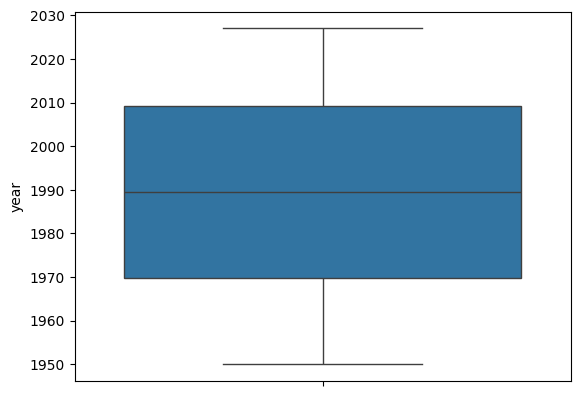

In [11]:
sns.boxplot(data= df, y="year")

The only other numerical variable is the views variable. Therefore outliers are checked using a scatterplot. [TO BE DEALT FURTHER]

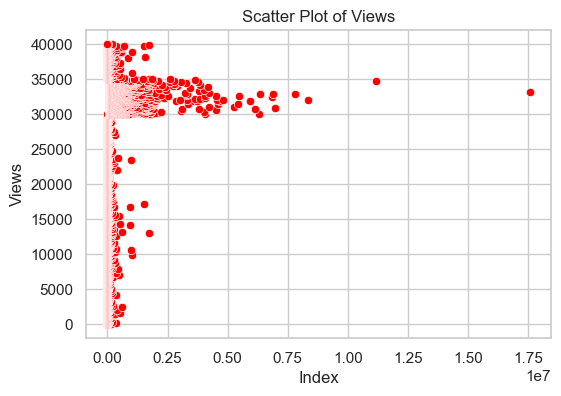

In [13]:
sns.set(style="whitegrid")

# Create a scatter plot for 'views'
plt.figure(figsize=(6, 4))
sns.scatterplot(data= df, y=df.index, x='views', color='red')
plt.title('Scatter Plot of Views')
plt.xlabel('Index')
plt.ylabel('Views')
plt.show()


### Checking Duplicates

In [14]:
# Check the duplicates in the lyrics variable
duplicates_lyrics = df[df.duplicated(subset='lyrics')]

In [15]:
# Set the max_rows option to None
pd.set_option('display.max_rows', None)

print(duplicates_lyrics['lyrics'].value_counts())

lyrics
[Instrumental Track]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

In [16]:
matching_observations = duplicates_lyrics[duplicates_lyrics['lyrics'].str.startswith("Sunday is gloomy")]

print(matching_observations)


               title  tag                          artist  year  views  \
655    Gloomy Sunday  pop  Woody Herman and His Orchestra  1958     11   
4373   Gloomy Sunday  pop                Claudia Thompson  1959     13   
4672   Gloomy Sunday  pop      The Creed Taylor Orchestra  1958      9   
4971   Gloomy Sunday  pop            Jerry Wald Orchestra  1955      5   
5778   Gloomy Sunday  pop                Lorez Alexandria  1961      6   
6122   Gloomy Sunday  pop               Genesis (Hungary)  1968    241   
18563  Gloomy Sunday  pop                   Cats Laughing  1988      4   

                                                  lyrics language  
655    Sunday is gloomy, my hours are slumberless\nDe...       en  
4373   Sunday is gloomy, my hours are slumberless\nDe...       en  
4672   Sunday is gloomy, my hours are slumberless\nDe...       en  
4971   Sunday is gloomy, my hours are slumberless\nDe...       en  
5778   Sunday is gloomy, my hours are slumberless\nDe...       en  

Observations:

There are two types of duplicates: 
1. Missing Lyrics that include
    - Instrumental Track or chorus that do not have the lyrics.
    - Songs for which the lyrics has not been released  
    - Songs for which the lyrics has been deleted.
2. Duplicate od lyrics: There are still some songs that share identical lyrics. However, upon closer inspection, it appears that these duplicates stem from the same title and lyrics, but performed by different artists and released in different years. These ar eprobably covers and remix. Therefore for future feature enginerring only the first insatnce of the song will be kept. 

## Class Imbalance

/Users/elenadelgovernatore/Desktop/GitHub/NLP/src/utils/utils_eda.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=decade_counts.index, y=decade_counts.values, palette=sns.color_palette("Blues_r", len(decade_counts)), ax=axes[1])


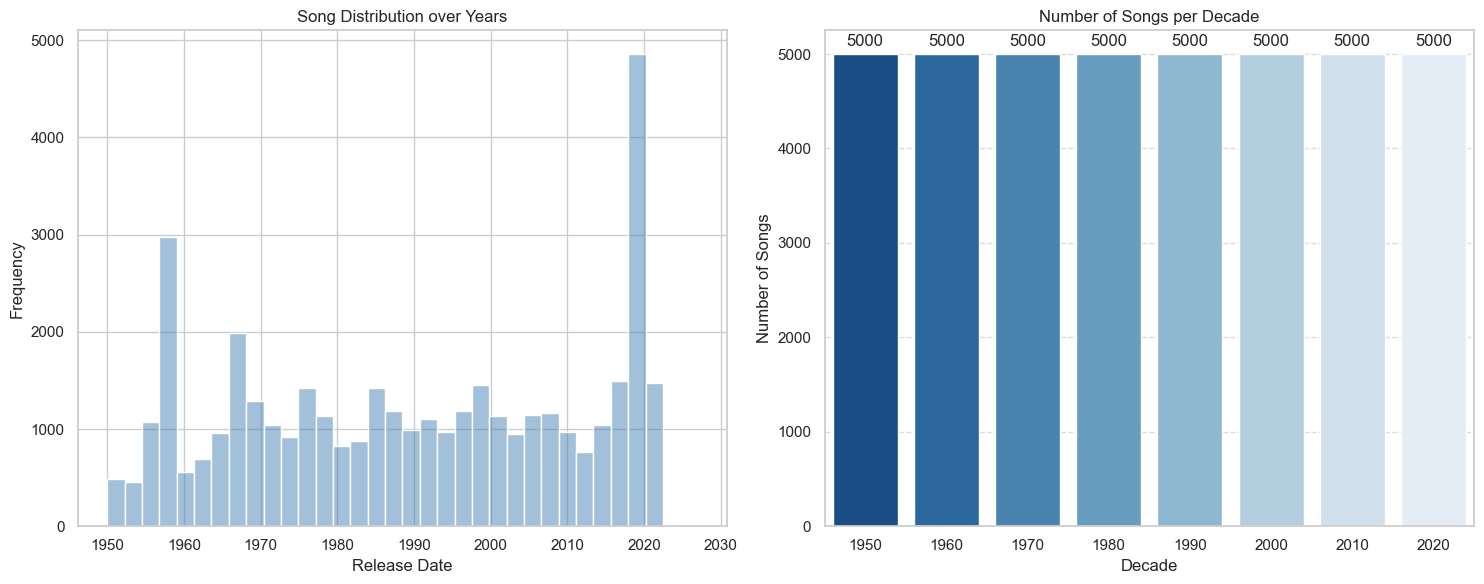

In [17]:
eda.class_balance()

Observations: 
-  Despite these fluctuations, all years are generally well and evenly represented.
- there are few peaks across different decades. For example, in the 1950s, the highest number of songs was recorded towards the end of the decade. Regarding the 2020s, it's logical that songs recorded are concentrated in the early years of the decade.

## Genre Feature Analysis

/Users/elenadelgovernatore/Desktop/GitHub/NLP/src/utils/utils_eda.py:91: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  axes[0].text(i, genre_counts[i] + 10, f'{val * 100:.2f}%', ha='center', va='bottom')


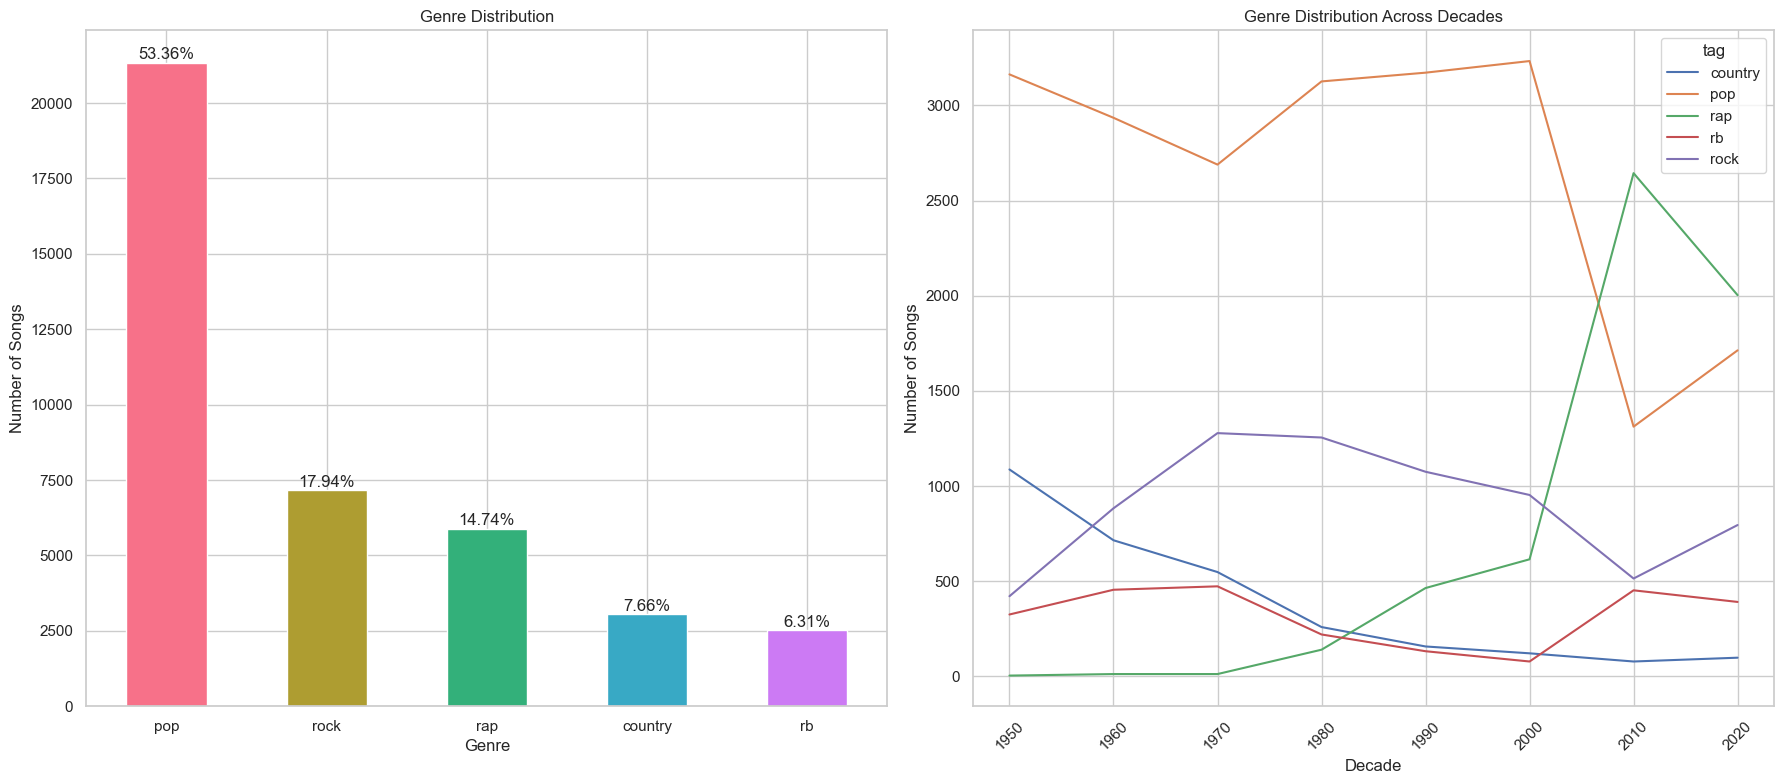

In [18]:
eda.genre_analysis()

Observations:
- The graph shows that pop is the genre with the most songs, followed by rock and rock. Slightly fewer songs are in country music and the final category with the fewest songs in our dataset is R&B.
- The grpah provides insights into the distribution of different music genres across the decades, showcasing how the popularity of these genres has evolved over time.

    - **Country:**  The genre saw a steady presence starting from the 1950s, with a gradual decline into the 1970s. The popularity of country music shows fluctuations but maintains a stable lower presence from the 1980s onwards.

    - **Pop:** The genre has a dominant presence from the beginning of the dataset, consistently staying high from the 1950s through the 2000s.The genre peaks around the 2000s but sees a noticeable drop in the 2010s, though it remains a significant part of the music scene.

    -  **Rap:** The genre starts with negligible presence in the early decades, becoming more prominent in the late 1980s and peaking around the 2000s. There's a marked increase in the 1990s and 2000s, reflecting the genre's rise to mainstream popularity.

    - **R&B:** The genre maintains a rather low but steady presence across the decades.R&B songs experiences minor fluctuations but show resilience and consistency, particularly noticeable from the 1960s onwards.

    - **Rock:** The genre shows a strong initial presence in the 1950s, peaking around the 1970s and 1980s. There is a gradual decline after 1980s, yet rock remains a significant genre throughout the years.

    - **Insights:** Pop songs are dominant through nearly all decades with the exception of a drop in the 2010s.  Rap songs shows significant growth starting from the 1980s, indicating its rise as a major genre in recent decades.Genres like Country and R&B have steady but fluctuating presences, indicating niche yet persistent popularity. While rock songs were very popular mid-century (1950s), they show a gradual decline after 1980s, possibly reflecting changing musical tastes and the rise of other genres like rap.

## Lyrics Analysis

#### Overview

In [19]:
#Analyzing lyrics
lyric_row_0 = df.loc[0, 'lyrics']
print(lyric_row_0)

Well completely sweet that's my baby
Completely sweet, I don't mean maybe
Well completely sweet that's my baby
Completely sweet, I don't mean maybe
And I love her more 'n' more each day
She's so completely sweet

Well a-just like a-honey, that the bees bring in
Mmm, a-just like a honey, that the bees bring in
Mmm, I get my sugar, when I kiss her on the chin

Well completely sweet that's my baby
Completely sweet, I don't mean maybe
Well completely sweet that's my baby
Completely sweet, I don't mean maybe
And I love her more 'n' more each day
She's so completely sweet

Well the sugar in my coffee, well the sugar in my tea
Well the sugar in my coffee, mmmm the sugar in my tea
Mmm, they both taste better, with a sugar on my knee
Well completely sweet that's my baby
Completely sweet, I don't mean maybe
Well completely sweet that's my baby
Completely sweet, I don't mean maybe
And I love her more 'n' more each day
She's so completely sweet
So completely sweet


In [20]:
#Analyzing lyrics
lyric_row_1 = df.loc[1, 'lyrics']
print(lyric_row_1)

The closer you are
The brighter, the stars in the sky
And darling, I realize
You're the one in my life for

My heart skips a beat every time
You and I meet my life, my love, my dear
I can't defeat that yearning deep
In my heart to have only you

When I first saw you
I did adore you and your loving way
And then you went away but now you're back to stay
And my love for you grows stronger every day

The closer you are
The brighter, the flames in my heart
And darling, we'll never part
We'll always be in love

When I first saw you
I did adore you and your loving way
And then you went away but now you're back to stay
And my love for you grows stronger every day
The closer you are
The brighter, the flames in my heart
And darling, we'll never part
We'll always be in love
Whoa, in love, whoa, in love


In [21]:
#Analyzing lyrics
lyric_row_2 = df.loc[2, 'lyrics']
print(lyric_row_2)

Uh-huh-huh, uh-huh-huh
Well I see a pretty girl walking down the street
Uh-huh-huh, uh-huh-huh
Well I see a pretty girl walking down the street
I'm gonna walk right up I'm gonna say real sweet
Uh-huh-huh, mm, mm

Uh-huh-huh, huh-huh-huh-huh
Well I say hey baby, baby who's your guy
Uh-huh-huh, uh-huh-huh
Well I say hey baby, baby who's your guy
Cause he can't love you as good as I
Uh-huh-huh, mm, mm

Uh-huh-huh, huh-huh-huh-huh
She looks into my eyes, we both are hypnotized
She puts her hand in mine
Afraid she'll jerk around and hurt my spine

Well my baby's kisses are jet propelled
Uh-huh-huh, uh-huh-huh
Well my baby's kisses are jet propelled
And man oh man she makes me feel so well
Uh-huh-huh, mm, mm, uh-huh-huh, huh-huh-huh-huh
She looks into my eyes, we both are hypnotized
She puts her hand in mine
Afraid she'll jerk around and hurt my spine
Well my baby's kisses are jet propelled
Uh-huh-huh, uh-huh-huh
Well my baby's kisses are jet propelled
And man oh man she makes me feel so wel

**Insights on the examples:**
- Example 1 and 3 feature a significant amount of repetition. This is a common technique in music to reinforce the theme or the main idea of the song, making it more memorable. Phrases such as "completely sweet" and "uh-huh-huh" are repeated multiple times, emphasizing the sentiment or creating a catchy rhythm.
- All three examples display a focus on love and affection in different wordings.
- There are metaphors, for example lyric 1 uses food-related metaphors ("like a honey," "sugar in my coffee") to describe the sweetness of the beloved, which conveys affection and endearment.
- Structure of lyric examples 1 and 3 have a simpler, repetitive structure, possibly indicating a more casual or upbeat song style.
Lyric example 2 has a more narrative and poetic structure, indicating a ballad or romantic song.

**Insights on the lyrics structure**

These three lyric examples show how lyrics are usually structured. There are some common patterns among lyrics:
- The square brackets often contain instructions that have nothing concrete to do with the lyrics, such as the name of the producer, intro, verse or outro, similar to stage directions in plays. As these instructions or information are not relevant for analyzing the explicit lyrics, they must be removed in preprocessing.
- Expressions of the background singers are recorded in round brackets, such as (Oooh). Whether these are relevant for the analysis of the lyrics is also questionable.

#### WordCloud

Performing TF-IDF vectorization...


Generating Word Clouds grouped by tag...


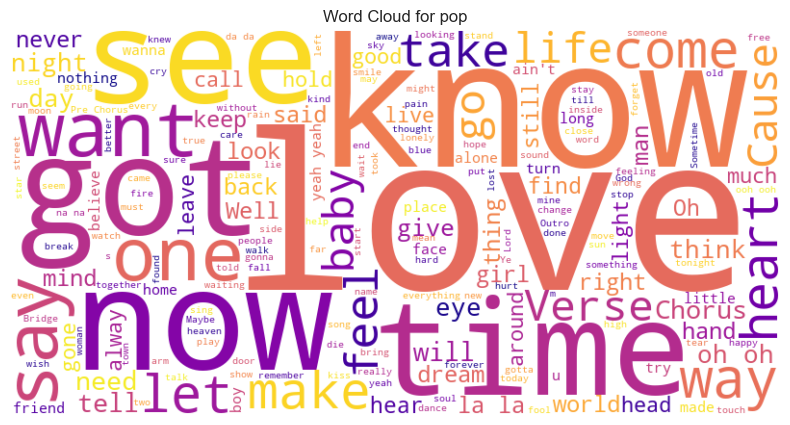

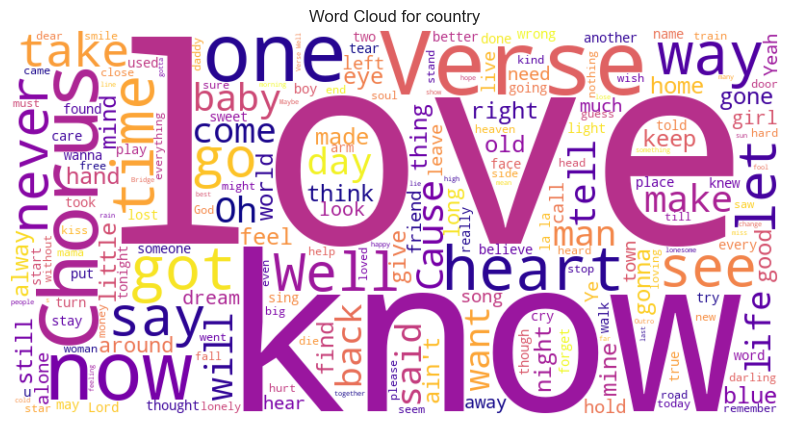

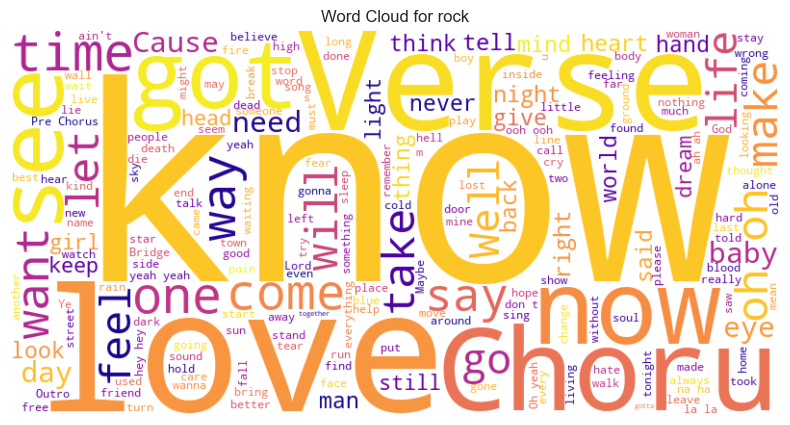

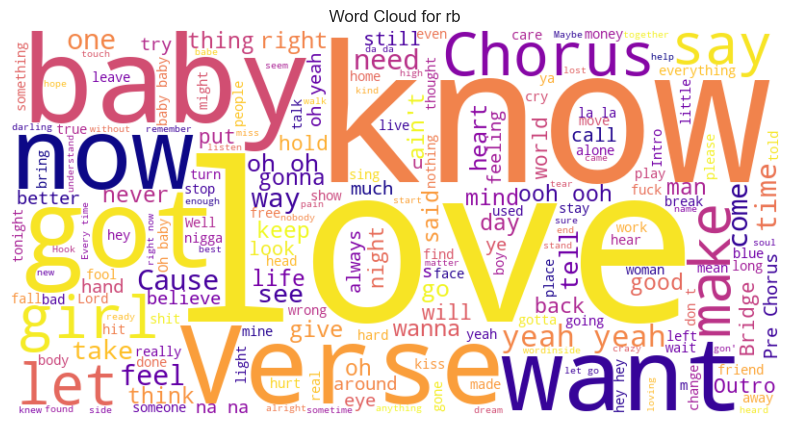

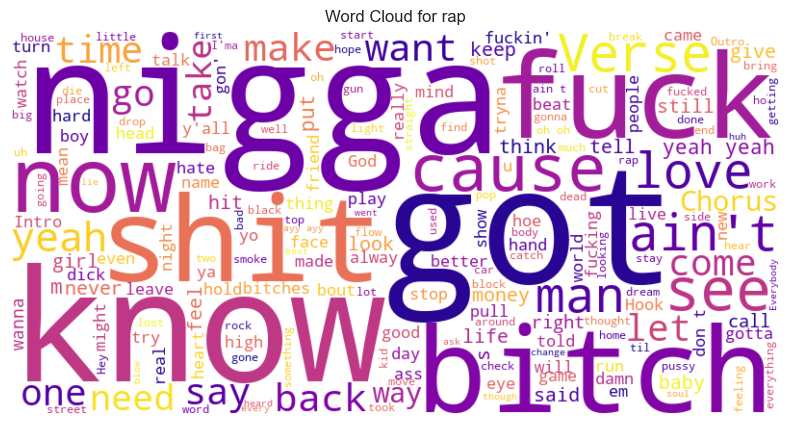

In [30]:
# word cloud by genre
generate_wordclouds(
    df=df,
    text_column='lyrics',
    group_by_column='tag',
    wordcloud_palette='plasma'
)

Performing TF-IDF vectorization...


Generating Word Clouds grouped by decade...


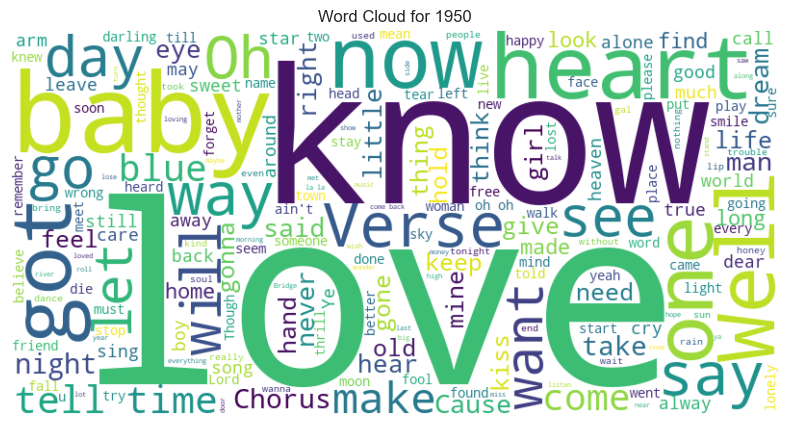

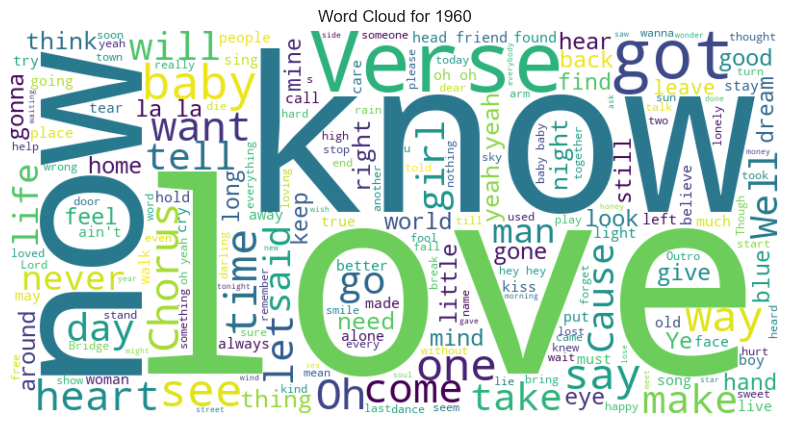

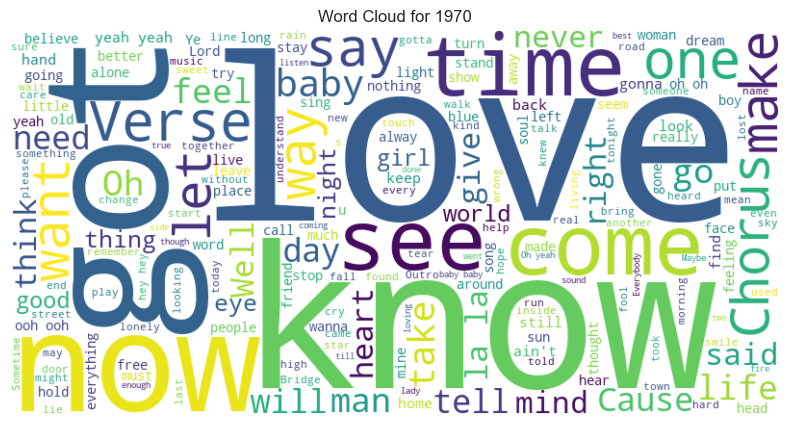

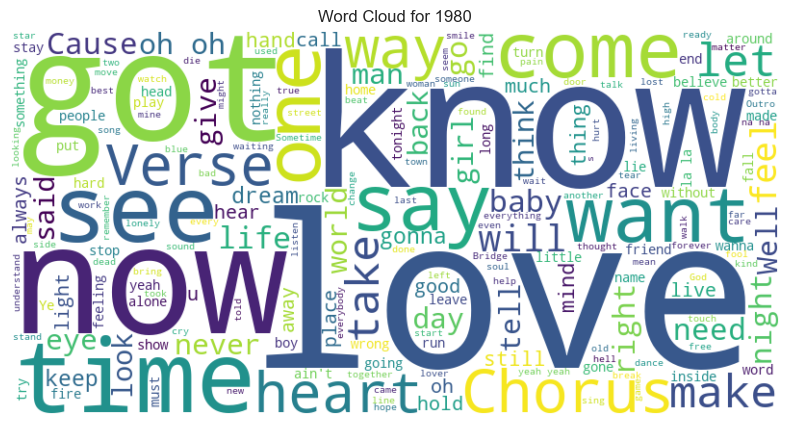

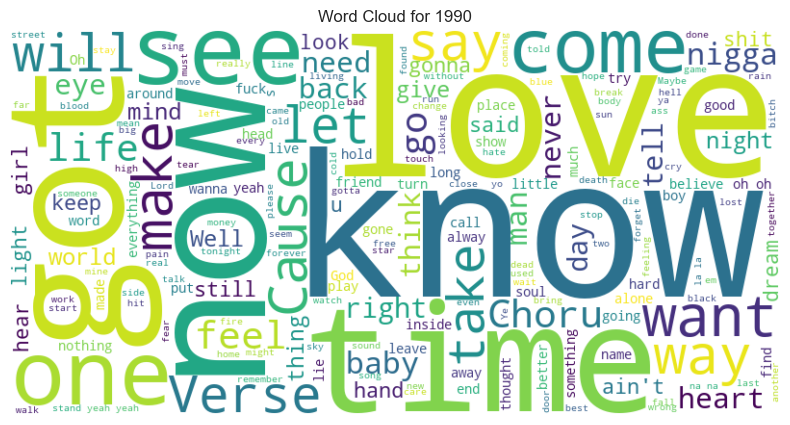

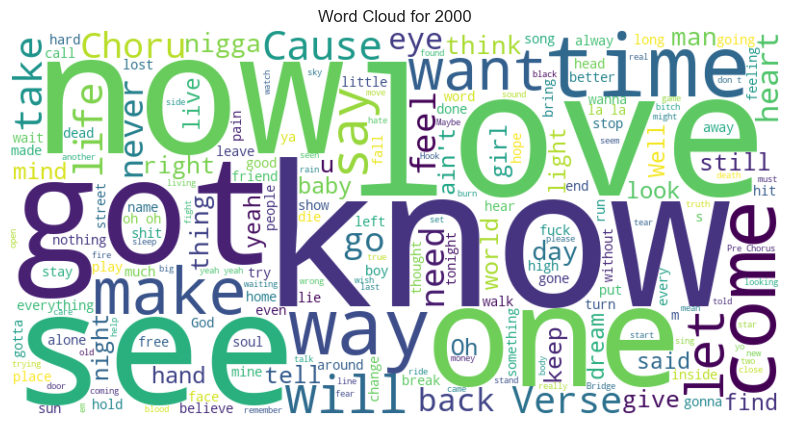

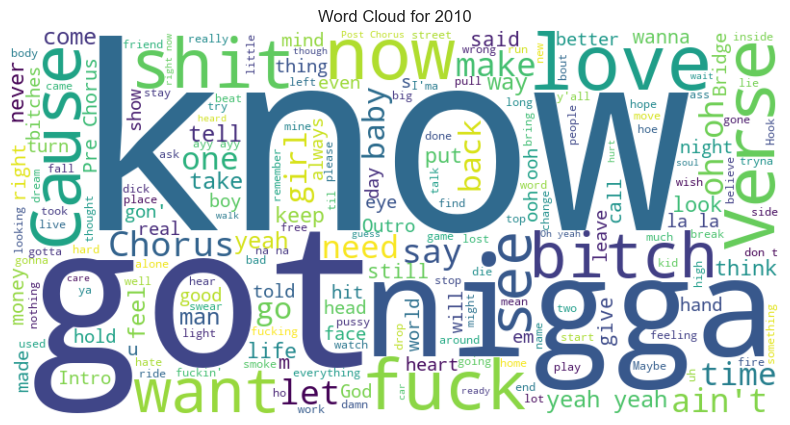

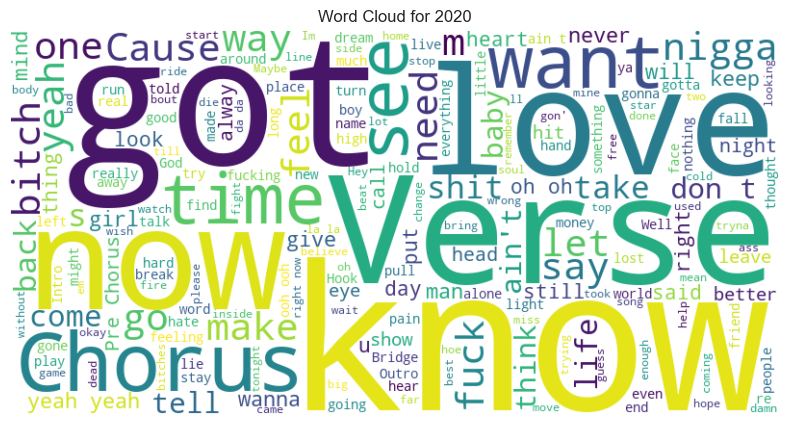

In [31]:
# word cloud by decade
generate_wordclouds(
    df=df,
    text_column='lyrics',
    group_by_column='decade',
    wordcloud_palette='viridis'
)


It is interesting to see how lyrics change over the time period. After 2000s the word "Love" for example stops weighing as much and more negative words along the lines of "bith" start appearing.

#### Sentiment Analysis

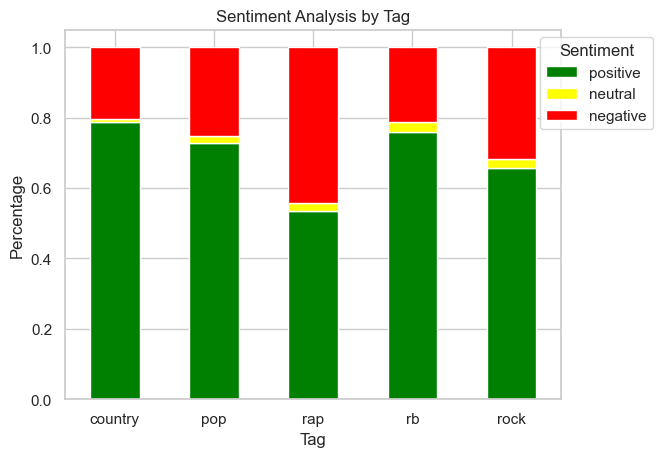

In [32]:
#sentiment by genre
sentiment_df_genre = analyzer.plot_sentiment(
    df=df,
    text_column='lyrics',
    group_by_column='tag'
)

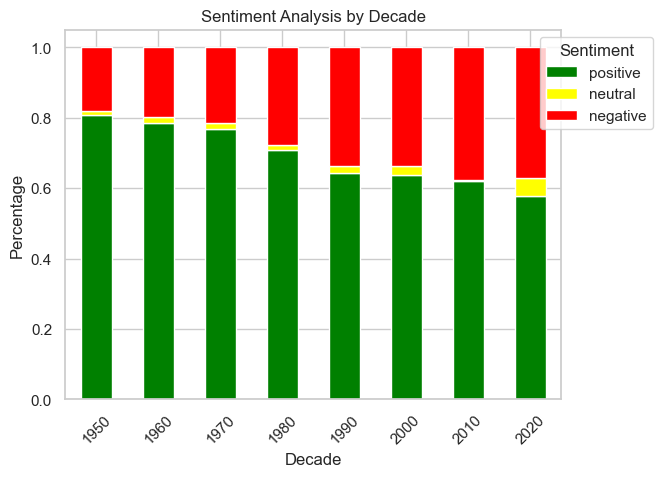

In [33]:
# sentiment by decade
sentiment_df_decade = analyzer.plot_sentiment(
    df=df,
    text_column='lyrics',
    group_by_column='decade'
)

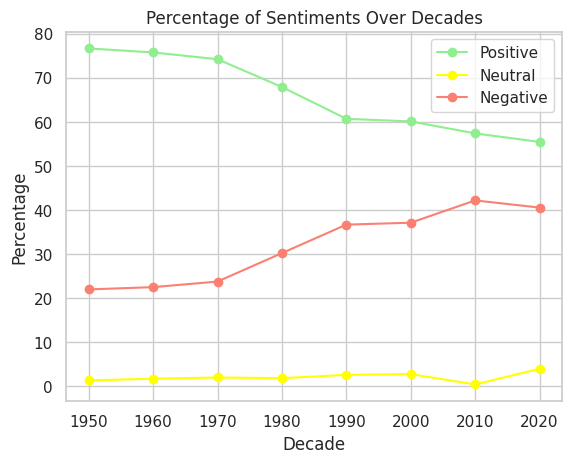

In [ ]:
sentiment_df_decade = analyzer.plot_sentiment_overdecades(
    df=df,
    text_column='lyrics'
)

Observations:
- Genre Sentiment Anayalsis Findings: 
    - Among all genres, rap has the highest proportion of negative sentiments at around 50%. The other genres have more positive lyrics on average. 
    - Country music lyrics are the most positive. 
    - all the genres do not show a huge amount of neutral terms, it seems instead that either terms are classified as positive or as negative.
- Deacade Sentiment Analysis Findings: 
    - an increasing pattern in negative sentiments,
    - a decreasing trend in positive sentiments,
    - neutral sentiments almost cancelling out with time, with the exceptance of the 2020s where neatural sentiments increase again.
    - with time, the prevalence of negative sentiments has steadily increased, while conversely, the occurrence of positive sentiments has declined. This temporal shift in sentiment distribution may reflect broader societal or cultural changes over the years, indicating evolving emotional landscapes within the lyrical content of the music industry.



#### Topic Modelling

In [35]:
lda_vis = topic_modeling(df, text_column='lyrics')

In [36]:
pyLDAvis.display(lda_vis)

Each topic is numbered and described by a combination of words and their corresponding probabilities. More precisely, it reveals that the most important topics addressed within the songs fell into three thematic areas: "Love and Relationships", "Profanity and Confrontation" and "Wealth and Materialism".

In line with it, some highly probable words in some topics are ‘love’, ‘baby’ , ‘time’, ‘away’, ‘ fuck’, ‘bitch’ or ‘shit’.  
